In [ ]:
## New notebook to carry out some of the trickier analysis on binned intensity ##
# GOAL: Would like to find a mean intensity at each box as well as a standard deviation
# Will agglomerate all points within a given range (currently 15-days and 2 degrees) and spit out an answer.

#the end vision is to have a 3-panel plot with decadal frequency change, intensity chance and f*i change
#effectively, to give a causality to changes in banded rainfall already observed in the banded rainfall plot.

In [4]:
import numpy as np
import time
import os
import netCDF4 as nc
import datetime
import matplotlib.pyplot as plt
#import masked arrays - important because intensity shows up as a NaN at some points
import numpy.ma as ma
%matplotlib notebook

In [5]:
## LOAD FROM NETCDF FILE ##
savefile = "RDA_int_hov"
ferretpath = "/Users/Siwen/Desktop/Ferret/bin/"

#netCDF output file formatting formatting
hovname = ferretpath + savefile + ".nc"
hovnc = nc.Dataset(hovname, "r")

#populate lists with intensity occupancy plots for each different time period (periods given below)
yr_beg = [1951,1951,1980,1980,1994]
yr_end = [2007,1979,2007,1993,2007]

#initialize intensity occupancy matrix storage
ints_1_hov = []
ints_2_hov = []
ints_hov = []

for yr_b, yr_e in zip(yr_beg, yr_end):

    years = str(yr_b-1900) + str("{0:0=2d}".format((yr_e-1900)%100))
    print(years)
    
    ints_1_hov.append(hovnc['int_1_hov_' + years][:])
    ints_2_hov.append(hovnc['int_2_hov_' + years][:])
    ints_hov.append(hovnc['int_hov_' + years][:])
    
hovnc.close()

5107
5179
8007
8093
9407


In [12]:
##collect function designed to aggregate all observations from 3D storage matrix - takes every ensemble (3rd dimension)
#then selections range of days and latitude range (I've mostly been using 15 day and 2 degree-latitude smoothing)

#RETURNS every non-NaN observation, as a single numpy array
#inputs: P is the full 3D matrix, dd is the day of interest(0-364), yy is the latitude bin of interest (likely 0-21)
def collect(P,dd,latbin,dayrange,latrange):
        
    ll=int((dayrange-1)/2)
    yy=int((latrange-1)/2)
    
    days = P.shape[0]
    lats = P.shape[1]
    
    Psample = P.take(range(dd-ll,dd+ll+1), mode='wrap', axis=0)
    P_collect = Psample[:,max(0,latbin-yy):min(days,latbin+yy+1),:].flatten()
    P_return = P_collect[~np.isnan(P_collect)]
    #print(len(P_collect))
    #print(len(P_return))
    
    return P_collect[~np.isnan(P_collect)]

In [13]:
collect(ints_hov[0], 300, 4, 15, 5)

array([ 23.36726996,  17.76521089,  20.45413306,  29.1540499 ,
        18.05255094,  11.0834208 ,  12.62752399,  16.43928646,
        57.72936945,  39.4053327 ,  20.56310143,  31.1156937 ,
        49.09804515,  40.05472993,  29.04730072,  24.6422515 ,
        22.24748301,  34.63161446,  12.15921136,  17.38620831,
        26.39094446,  15.07890138,  15.94646255,  29.93557753,
        11.04294947,  20.33773751,  45.10287412,  27.77153342,
        20.61953535,  15.3016004 ,  26.50325706,  12.89271385,
        22.06989196,  16.87793584,  16.46374964,  16.12566854,
        23.56461492,  19.21219114,  14.01786869,  20.0609555 ])

In [43]:
## for each day and each latitude bin, use collect to find the intensity of all events in range, then find mean
#and standard deviation.
#unfortunately, can't just one-shot it (must go cell-by-cell) because cannot predict the length of the output from collect

ints_1_hov_mean = []
ints_2_hov_mean = []
ints_hov_mean = []

ints_1_hov_std = []
ints_2_hov_std = []
ints_hov_std = []

dayrange = 15
latrange = 5

for ints_1, ints_2, ints in zip(ints_1_hov, ints_2_hov, ints_hov):
    
    #initialize temporary results storage
    ints_1_mean = np.zeros([365,22])
    ints_2_mean = np.zeros([365,22])
    ints_mean = np.zeros([365,22])
    
    ints_1_std = np.zeros([365,22])
    ints_2_std = np.zeros([365,22])
    ints_std = np.zeros([365,22])
    
    for dd in range(365):
        for jj in range(22):
            intcol = collect(ints_1, dd, jj, dayrange, latrange)
            ints_1_mean[dd,jj] = np.mean(intcol)
            ints_1_std[dd,jj] = np.std(intcol)
            
    #append to permanent results storage            
    ints_1_hov_mean.append(ints_1_mean)
    ints_2_hov_mean.append(ints_2_mean)
    ints_hov_mean.append(ints_mean)
    
    ints_1_hov_std.append(ints_1_std)
    ints_2_hov_std.append(ints_2_std)
    ints_hov_std.append(ints_std)



//anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
//anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
//anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
//anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
//anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
//anaconda/lib/python3.5/site-packages/numpy/ma/core.py:4089: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warnin

In [46]:
print(ints_1_hov_mean[0][:,0])

[         nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan  48.03392166  48.03392166  48.03392166  48.03392166
  48.03392

(365, 22)


<IPython.core.display.Javascript object>


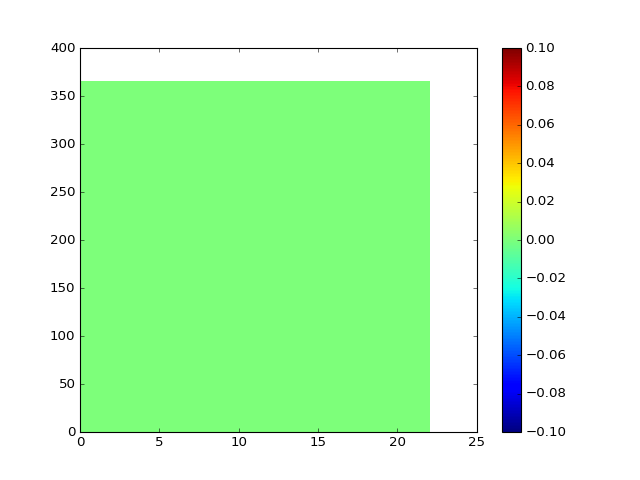

In [40]:
qq = ints_1_hov_mean[0]
qq[np.isnan(qq)] = 0
print(qq.shape)

fig, ax = plt.subplots()
ax = plt.pcolormesh(qq)
plt.colorbar()

In [10]:
aa = [5, 4, 3, 5, 5, 6, 7, 4]
print(np.std(aa))

1.16592238164


In [41]:
np.std([100])

0.0